# Imports

In [1]:
import numpy as np
import gymnasium as gym
import random
import time
from IPython.display import clear_output
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
from mdptoolbox import mdp
from scipy.optimize import linprog
from itertools import product   
import matplotlib as mpl

The environment has a 4x4 grid, with a total of 16 states. There are four possible actions: move left, move down, move right, or move up. 

In [2]:
slippery=True

In [3]:
env = gym.make("FrozenLake-v1", map_name = "4x4", is_slippery=slippery)

In [4]:
print("Number of states:", env.observation_space.n)
print("Number of actions:", env.action_space.n)

Number of states: 16
Number of actions: 4


# Initialize the Q-table:

Create a Q-table with dimensions equal to the number of states and actions. Initialize the table with zeros:

In [5]:
q_table = np.zeros((env.observation_space.n, env.action_space.n))

# Hyperparameters

In [6]:
total_episodes = 200000
learning_rate = 0.05
max_steps = 100
gamma = 0.99
exploration_rate = 1
max_exploration_rate = 1
min_exploration_rate = 0.01
exploration_decay_rate = 0.00005

# Q-learning

In [7]:
rewards_all_episodes = []

for episode in tqdm(range(total_episodes)):
    state = env.reset()[0]
    done = False
    rewards_current_episode = 0

    for step in range(max_steps):
        exploration_threshold = random.uniform(0, 1)
        if exploration_threshold > exploration_rate:
            action = np.argmax(q_table[state, :])
        else:
            action = env.action_space.sample()
        new_state, reward, done, info, prob = env.step(action)

        q_table[state, action] = q_table[state, action] * (1 - learning_rate) + \
            learning_rate * (reward + gamma * np.max(q_table[new_state, :]))
        state = new_state
        rewards_current_episode += reward
        if done:
            break
    exploration_rate = min_exploration_rate + \
        (max_exploration_rate - min_exploration_rate) * np.exp(-exploration_decay_rate * episode)
    rewards_all_episodes.append(rewards_current_episode)

print("Q-table:")
print(q_table)


100%|██████████| 200000/200000 [01:35<00:00, 2097.96it/s]

Q-table:
[[0.55263532 0.50649613 0.50523681 0.50569326]
 [0.29660964 0.35175457 0.34317249 0.49903797]
 [0.42039211 0.42387221 0.41720776 0.46295333]
 [0.32221685 0.27919144 0.30427559 0.44810524]
 [0.56787591 0.42530093 0.34738455 0.35905931]
 [0.         0.         0.         0.        ]
 [0.23984841 0.16088385 0.37644947 0.21347115]
 [0.         0.         0.         0.        ]
 [0.35816089 0.35016442 0.32749142 0.62024819]
 [0.46833035 0.68019506 0.46425814 0.43072886]
 [0.63701978 0.45661055 0.45463952 0.29763121]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.57360259 0.42503044 0.83158493 0.52724735]
 [0.73849179 0.92202668 0.79307829 0.78885498]
 [0.         0.         0.         0.        ]]


In [8]:
def plot_policy(policy):
    reshaped_policy = policy.reshape(4,4)
    plt.imshow([[0,0,0,0],[0,1,0,1],[0,0,0,1],[1,0,0,-1] ], cmap=mpl.colormaps["Pastel1"], interpolation='nearest')

    #left arrow if action is 0
    for i in range(4):
        for j in range(4):
            if reshaped_policy[i][j] == 0:
                plt.annotate('', xy=(j,i), xytext=(j+0.3,i), arrowprops=dict(facecolor='black', width=0.5, headwidth=5))
    #down arrow if action is 1
    for i in range(4):
        for j in range(4):
            if reshaped_policy[i][j] == 1:
                plt.annotate('', xy=(j,i), xytext=(j,i-0.3), arrowprops=dict(facecolor='black', width=0.5, headwidth=5))
    #right arrow if action is 2
    for i in range(4):
        for j in range(4):
            if reshaped_policy[i][j] == 2:
                plt.annotate('', xy=(j,i), xytext=(j-0.3,i), arrowprops=dict(facecolor='black', width=0.5, headwidth=5))
    #up arrow if action is 3
    for i in range(4):
        for j in range(4):
            if reshaped_policy[i][j] == 3:
                plt.annotate('', xy=(j,i), xytext=(j,i+0.3), arrowprops=dict(facecolor='black', width=0.5, headwidth=5))
    plt.show()

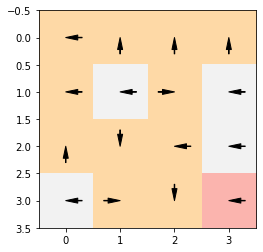

In [9]:
policy = np.argmax(q_table,axis=1)

plot_policy(policy)

# Evaluate the agent's performance:

In [13]:
rewards_per_thousand_episodes = np.split(np.array(rewards_all_episodes), total_episodes / 10000)
count = 10000
print("********* Average reward per 10 thousand episodes *********\n")
for r in rewards_per_thousand_episodes:
    print(count, ": ", str(sum(r / 10000)))
    count += 10000

********* Average reward per 10 thousand episodes *********

10000 :  0.02739999999999989
20000 :  0.07170000000000103
30000 :  0.14959999999999984
40000 :  0.2505999999999887
50000 :  0.3741999999999751
60000 :  0.45829999999996585
70000 :  0.5458999999999562
80000 :  0.5961999999999507
90000 :  0.6272999999999472
100000 :  0.6582999999999438
110000 :  0.6632999999999433
120000 :  0.6759999999999419
130000 :  0.6762999999999418
140000 :  0.6868999999999407
150000 :  0.6948999999999398
160000 :  0.6847999999999409
170000 :  0.6810999999999413
180000 :  0.6876999999999406
190000 :  0.6866999999999407
200000 :  0.6869999999999407


# Test performance 

Require pygame and opens a new window

In [11]:
num_test_episodes = 3
env = gym.make("FrozenLake-v1", map_name = "4x4", is_slippery=slippery, render_mode="human")
for episode in range(num_test_episodes):
    state = env.reset()[0]
    done = False
    for step in range(max_steps):
        action = np.argmax(q_table[state, :])
        new_state, reward, done, info, prob = env.step(action)
        if done:
            break

        state = new_state

env.close()

# IRL

Now, given the q-table, we try to recover the reward function 

# Maximum margin method 

In [11]:

def compute_feature_expectations(env, policy, num_states, num_actions, discount_factor, num_trajectories, trajectory_length):
    feature_expectations = np.zeros(num_states)

    for _ in range(num_trajectories):
        state = env.reset()[0]
        for _ in range(trajectory_length):
            action = policy[state]
            feature_expectations[state] += discount_factor 
            state, _, done, _, _ = env.step(action)
            if done:
                break

    return feature_expectations / num_trajectories

def max_margin_irl(feature_matrix, feature_expectations, num_states, num_actions, discount_factor, num_trajectories, trajectory_length):
    c = np.concatenate([np.zeros(num_states), np.ones(num_trajectories)])
    A_ub = []
    b_ub = []

    for trajectory in tqdm(range(num_trajectories)):
        state = env.reset()[0]
        for t in range(trajectory_length):
            action = np.argmax(q_table[state, :])
            next_state, _, done, _, _ = env.step(action)
            immediate_reward = feature_matrix[state, :] - discount_factor * feature_matrix[next_state, :] 
            A_ub.append(np.concatenate([-immediate_reward, np.zeros(num_trajectories)]))
            A_ub[-1][num_states + trajectory] = -1.0
            b_ub.append(0)
            state = next_state
            if done:
                break

    A_eq = [np.concatenate([feature_expectations, np.zeros(num_trajectories)])]
    b_eq = [1]

    bounds = [(0, None) for _ in range(num_states)] + [(None, None) for _ in range(num_trajectories)]

    result = linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, bounds=bounds)

    return result.x[:num_states]

# Hyperparameters
num_states = env.observation_space.n
num_actions = env.action_space.n
discount_factor = 1
num_trajectories = 1000
trajectory_length = 100

env = gym.make("FrozenLake-v1", map_name = "4x4", is_slippery=slippery)
feature_matrix = np.eye(num_states)
expert_policy = np.argmax(q_table, axis=1)
feature_expectations = compute_feature_expectations(env, expert_policy, num_states, num_actions, discount_factor, num_trajectories, trajectory_length)

reward_function = max_margin_irl(feature_matrix, feature_expectations, num_states, num_actions, discount_factor, num_trajectories, trajectory_length)

print("Reward Function:")
print(reward_function)


100%|██████████| 1000/1000 [00:00<00:00, 1646.77it/s]


Reward Function:
[0.02249668 0.02249668 0.02249668 0.02249668 0.02249668 0.
 0.02249668 0.         0.02249668 0.02249668 0.02249668 0.
 0.         0.02249668 0.02249668 0.        ]


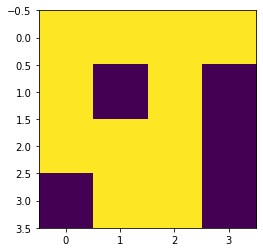

In [12]:
plt.imshow(reward_function.reshape(4,4))

strange result

# Max entropy

Implementation is a modification of this repo https://github.com/qzed/irl-maxent/tree/master

In [14]:
class Optimizer:
    """
    Optimizer base-class.

    Note:
        Before use of any optimizer, its `reset` function must be called.

    Attributes:
        parameters: The parameters to be optimized. This should only be set
            via the `reset` method of this optimizer.
    """
    def __init__(self):
        self.parameters = None

    def reset(self, parameters):
        """
        Reset this optimizer.

        Args:
            parameters: The parameters to optimize.
        """
        self.parameters = parameters

    def step(self, grad, *args, **kwargs):
        """
        Perform a single optimization step.

        Args:
            grad: The gradient used for the optimization step.

            Other arguments are optimizer-specific.
        """
        raise NotImplementedError

    def normalize_grad(self, ord=None):
        """
        Create a new wrapper for this optimizer which normalizes the
        gradient before each step.

        Returns:
            An Optimizer instance wrapping this Optimizer, normalizing the
            gradient before each step.

        See also:
            `class NormalizeGrad`
        """
        return NormalizeGrad(self, ord)

class ExpSga(Optimizer):
    """
    Exponentiated stochastic gradient ascent.

    The implementation follows Algorithm 10.5 from B. Ziebart's thesis
    (2010) and is slightly adapted from the original algorithm provided by
    Kivinen and Warmuth (1997).

    Note:
        Before use of any optimizer, its `reset` function must be called.

    Args:
        lr: The learning-rate. This may either be a float for a constant
            learning-rate or a function
            `(k: Integer) -> learning_rate: Float`
            taking the step number as parameter and returning a learning
            rate as result.
            See also `linear_decay`, `power_decay` and `exponential_decay`.
        normalize: A boolean specifying if the the parameters should be
            normalized after each step, as done in the original algorithm by
            Kivinen and Warmuth (1997).

    Attributes:
        parameters: The parameters to be optimized. This should only be set
            via the `reset` method of this optimizer.
        lr: The learning-rate as specified in the __init__ function.
        k: The number of steps run since the last reset.
    """
    def __init__(self, lr, normalize=False):
        super().__init__()
        self.lr = lr
        self.normalize = normalize
        self.k = 0

    def reset(self, parameters):
        """
        Reset this optimizer.

        Args:
            parameters: The parameters to optimize.
        """
        super().reset(parameters)
        self.k = 0

    def step(self, grad, *args, **kwargs):
        """
        Perform a single optimization step.

        Args:
            grad: The gradient used for the optimization step.
        """
        lr = self.lr if not callable(self.lr) else self.lr(self.k)
        self.k += 1

        self.parameters *= np.exp(lr * grad)

        if self.normalize:
            self.parameters /= self.parameters.sum()

class Initializer:
    """
    Base-class for an Initializer, specifying a strategy for parameter
    initialization.
    """
    def __init__(self):
        pass

    def initialize(self, shape):
        """
        Create an initial set of parameters.

        Args:
            shape: The shape of the parameters.

        Returns:
            An initial set of parameters of the given shape, adhering to the
            initialization-strategy described by this Initializer.
        """
        raise NotImplementedError

    def __call__(self, shape):
        """
        Create an initial set of parameters.

        Note:
            This function simply calls `self.initialize(shape)`.

        Args:
            shape: The shape of the parameters.

        Returns:
            An initial set of parameters of the given shape, adhering to the
            initialization-strategy described by this Initializer.
        """
        return self.initialize(shape)
class Constant(Initializer):
    """
    An Initializer, initializing parameters to a constant value.

    Args:
        value: Either a scalar value or a function in dependence on the
            shape of the parameters, returning a scalar value for
            initialization.
    """
    def __init__(self, value=1.0):
        super().__init__()
        self.value = value

    def initialize(self, shape):
        """
        Create set of parameters with initial fixed value.

        The scalar value used for initialization can be specified in the
        constructor.

        Args:
            shape: The shape of the parameters.

        Returns:
            An set of constant-valued parameters of the given shape.
        """
        if callable(self.value):
            return np.ones(shape) * self.value(shape)
        else:
            return np.ones(shape) * self.value

def linear_decay(lr0=0.2, decay_rate=1.0, decay_steps=1):
    """
    Linear learning-rate decay.

    Creates a function `(k: Integer) -> learning_rate: Float` returning the
    learning-rate in dependence on the current number of iterations. The
    returned function can be expressed as

        learning_rate(k) = lr0 / (1.0 + decay_rate * floor(k / decay_steps))

    Args:
        lr0: The initial learning-rate.
        decay_rate: The decay factor.
        decay_steps: An integer number of steps that can be used to
            staircase the learning-rate.

    Returns:
        The function giving the current learning-rate in dependence of the
        current iteration as specified above.
    """
    def _lr(k):
        return lr0 / (1.0 + decay_rate * np.floor(k / decay_steps))

    return _lr

def create_expert_trajectory(env, policy, n_trajectories):
    env.reset()
    trajectories = []
    expert_trajectory = []
    done = False
    for i in range(n_trajectories):
        while not done:
            action = policy[env.s]
            state, reward, done, info, prob = env.step(action)
            expert_trajectory.append([state, action])
        env.reset()
        trajectories.append(expert_trajectory)
        expert_trajectory = []
        done = False
    return trajectories



def feature_expectation_from_trajectories(features, trajectories):
    n_states, n_features = features.shape

    fe = np.zeros(n_features)

    for t in trajectories:
        states = [k[0] for k in t]# for each trajectory
        for s in states:                # for each state in trajectory
            fe += features[s, :]            # sum-up features

    return fe / len(trajectories)           # average over trajectories

def transition_matrix(env):
    transition_matrix = np.zeros((env.observation_space.n, env.observation_space.n, env.action_space.n))
    for i in range(env.observation_space.n):
        for j in range(env.action_space.n):
            for prob, next_state, reward, done in env.P[i][j]:
                transition_matrix[i][next_state][j] += prob
    return transition_matrix

def compute_expected_svf(p_transition, p_initial, terminal, reward, eps=1e-6):
    n_states, _, n_actions = p_transition.shape
    
    nonterminal = set(range(n_states)) - set(terminal)  # nonterminal states
    
    # Backward Pass
    # 1. initialize at terminal states
    zs = np.zeros(n_states, dtype=np.float32)                            # zs: state partition function
    zs[terminal] = 1.0

    # 2. perform backward pass
    for _ in range(2 * n_states):                       # longest trajectory: n_states
        # reset action values to zero
        za = np.zeros((n_states, n_actions), dtype=np.float32)            # za: action partition function

        # for each state-action pair
        for s_from, a in product(range(n_states), range(n_actions)):

            # sum over s_to
            for s_to in range(n_states):
                za[s_from, a] += p_transition[s_from, s_to, a] * np.exp(reward[s_from]) * zs[s_to]
                
        # sum over all actions
        
        zs = za.sum(axis=1)
        
        

    # 3. compute local action probabilities
    
    p_action = za / zs[:, None]
    
    # Forward Pass
    # 4. initialize with starting probability
    d = np.zeros((n_states, 2 * n_states))              # d: state-visitation frequencies
    d[:, 0] = p_initial

    # 5. iterate for N steps
    for t in range(1, 2 * n_states):                    # longest trajectory: n_states
        
        # for all states
        for s_to in range(n_states):
            
            # sum over nonterminal state-action pairs
            for s_from, a in product(nonterminal, range(n_actions)):
                d[s_to, t] += d[s_from, t-1] * p_action[s_from, a] * p_transition[s_from, s_to, a]

    # 6. sum-up frequencies
    return d.sum(axis=1)

def maxent_irl(p_transition, features, terminal, trajectories, optim, init, eps=1e-4):
    n_states, _, n_actions = p_transition.shape
    _, n_features = features.shape

    # compute feature expectation from trajectories
    e_features = feature_expectation_from_trajectories(features, trajectories)
    
    # compute starting-state probabilities from trajectories
    p_initial = np.zeros(n_states)
    p_initial[0] = 1
    

    # gradient descent optimization
    omega = init(n_features)        # initialize our parameters
    delta = np.inf                  # initialize delta for convergence check

    optim.reset(omega)              # re-start optimizer
    while delta > eps:              # iterate until convergence
        
        omega_old = omega.copy()

        # compute per-state reward from features
        reward = features.dot(omega)
        
        reward = reward/reward.max()
        
        # compute gradient of the log-likelihood
        e_svf = compute_expected_svf(p_transition, p_initial, terminal, reward)
        grad = e_features - features.T.dot(e_svf)

        # perform optimization step and compute delta for convergence
        optim.step(grad)
        
        # re-compute detla for convergence check
        delta = np.max(np.abs(omega_old - omega))

    # re-compute per-state reward and return
    return features.dot(omega)

policy = np.argmax(q_table, axis=1)
n_trajectories = 1000
trajectories = create_expert_trajectory(env, policy, n_trajectories)

# set up features: we use one feature vector per state
features = np.identity(env.observation_space.n)

# choose our parameter initialization strategy:
#   initialize parameters with constant
init = Constant(1.0)

# choose our optimization strategy:
#   we select exponentiated stochastic gradient descent with linear learning-rate decay
optim = ExpSga(lr=linear_decay(lr0=0.01))
transition_matrix_env = transition_matrix(env)


# actually do some inverse reinforcement learning
reward_maxent = maxent_irl(transition_matrix_env, features, [5,7,11,12,15], trajectories, optim, init)

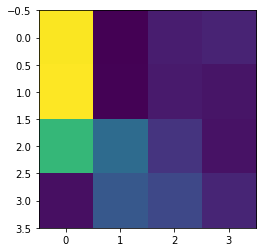

In [15]:
plt.imshow(reward_maxent.reshape(4,4))

In [ ]:
total_episodes = 200000
learning_rate = 0.01
max_steps = 100
gamma = 0.99
exploration_rate = 1
max_exploration_rate = 1
min_exploration_rate = 0.01
exploration_decay_rate = 0.00005
# Define Q-learning parameters

max_steps = 100
alpha = 0.8

epsilon = 1.0
max_epsilon = 1.0
min_epsilon = 0.01
decay_rate = 0.01


In [18]:

# Create environment
env = gym.make('FrozenLake-v1', map_name="4x4", is_slippery=slippery)

# Initialize Q-table to zeros
new_q_table = np.zeros((env.observation_space.n, env.action_space.n))
rewards_all_episodes = []

for episode in tqdm(range(total_episodes)):
    state = env.reset()[0]
    done = False
    rewards_current_episode = 0

    for step in range(max_steps):
        exploration_threshold = random.uniform(0, 1)
        if exploration_threshold > exploration_rate:
            action = np.argmax(new_q_table[state, :])
        else:
            action = env.action_space.sample()
        new_state, _, done, info, prob = env.step(action)
        reward = reward_maxent[new_state]
        new_q_table[state, action] = new_q_table[state, action] * (1 - learning_rate) + \
            learning_rate * (reward + gamma * np.max(new_q_table[new_state, :]))
        state = new_state
        rewards_current_episode += reward
        if done:
            break
    exploration_rate = min_exploration_rate + \
        (max_exploration_rate - min_exploration_rate) * np.exp(-exploration_decay_rate * episode)
    rewards_all_episodes.append(rewards_current_episode)


100%|██████████| 100000/100000 [01:08<00:00, 1458.34it/s]


[0 3 3 3 0 0 2 0 3 1 0 0 0 2 1 0]


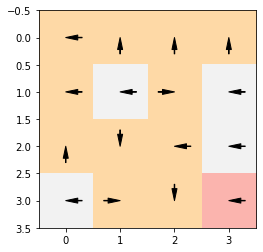

In [19]:
expert_policy = np.argmax(q_table,axis=1)
print(expert_policy)
plot_policy(policy)

[3 3 3 3 0 0 2 0 3 1 0 0 0 2 0 0]


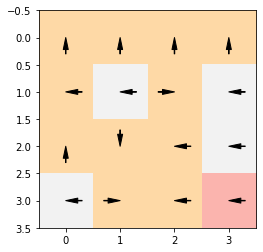

In [20]:
learned_policy = np.argmax(new_q_table,axis=1)
print(learned_policy)
plot_policy(learned_policy)

Observation: the agent will never reach the goal! that's because he is maximixing the reward of staying in the first cell

# Negative Max entropy

Here we add the negative examples: the agent should not do long walks 

In [21]:
class Optimizer:
    """
    Optimizer base-class.

    Note:
        Before use of any optimizer, its `reset` function must be called.

    Attributes:
        parameters: The parameters to be optimized. This should only be set
            via the `reset` method of this optimizer.
    """
    def __init__(self):
        self.parameters = None

    def reset(self, parameters):
        """
        Reset this optimizer.

        Args:
            parameters: The parameters to optimize.
        """
        self.parameters = parameters

    def step(self, grad, *args, **kwargs):
        """
        Perform a single optimization step.

        Args:
            grad: The gradient used for the optimization step.

            Other arguments are optimizer-specific.
        """
        raise NotImplementedError

    def normalize_grad(self, ord=None):
        """
        Create a new wrapper for this optimizer which normalizes the
        gradient before each step.

        Returns:
            An Optimizer instance wrapping this Optimizer, normalizing the
            gradient before each step.

        See also:
            `class NormalizeGrad`
        """
        return NormalizeGrad(self, ord)

class ExpSga(Optimizer):
    """
    Exponentiated stochastic gradient ascent.

    The implementation follows Algorithm 10.5 from B. Ziebart's thesis
    (2010) and is slightly adapted from the original algorithm provided by
    Kivinen and Warmuth (1997).

    Note:
        Before use of any optimizer, its `reset` function must be called.

    Args:
        lr: The learning-rate. This may either be a float for a constant
            learning-rate or a function
            `(k: Integer) -> learning_rate: Float`
            taking the step number as parameter and returning a learning
            rate as result.
            See also `linear_decay`, `power_decay` and `exponential_decay`.
        normalize: A boolean specifying if the the parameters should be
            normalized after each step, as done in the original algorithm by
            Kivinen and Warmuth (1997).

    Attributes:
        parameters: The parameters to be optimized. This should only be set
            via the `reset` method of this optimizer.
        lr: The learning-rate as specified in the __init__ function.
        k: The number of steps run since the last reset.
    """
    def __init__(self, lr, normalize=False):
        super().__init__()
        self.lr = lr
        self.normalize = normalize
        self.k = 0

    def reset(self, parameters):
        """
        Reset this optimizer.

        Args:
            parameters: The parameters to optimize.
        """
        super().reset(parameters)
        self.k = 0

    def step(self, grad, *args, **kwargs):
        """
        Perform a single optimization step.

        Args:
            grad: The gradient used for the optimization step.
        """
        lr = self.lr if not callable(self.lr) else self.lr(self.k)
        self.k += 1

        self.parameters *= np.exp(lr * grad)

        if self.normalize:
            self.parameters /= self.parameters.sum()

class Initializer:
    """
    Base-class for an Initializer, specifying a strategy for parameter
    initialization.
    """
    def __init__(self):
        pass

    def initialize(self, shape):
        """
        Create an initial set of parameters.

        Args:
            shape: The shape of the parameters.

        Returns:
            An initial set of parameters of the given shape, adhering to the
            initialization-strategy described by this Initializer.
        """
        raise NotImplementedError

    def __call__(self, shape):
        """
        Create an initial set of parameters.

        Note:
            This function simply calls `self.initialize(shape)`.

        Args:
            shape: The shape of the parameters.

        Returns:
            An initial set of parameters of the given shape, adhering to the
            initialization-strategy described by this Initializer.
        """
        return self.initialize(shape)
class Constant(Initializer):
    """
    An Initializer, initializing parameters to a constant value.

    Args:
        value: Either a scalar value or a function in dependence on the
            shape of the parameters, returning a scalar value for
            initialization.
    """
    def __init__(self, value=1.0):
        super().__init__()
        self.value = value

    def initialize(self, shape):
        """
        Create set of parameters with initial fixed value.

        The scalar value used for initialization can be specified in the
        constructor.

        Args:
            shape: The shape of the parameters.

        Returns:
            An set of constant-valued parameters of the given shape.
        """
        if callable(self.value):
            return np.ones(shape) * self.value(shape)
        else:
            return np.ones(shape) * self.value

def linear_decay(lr0=0.2, decay_rate=1.0, decay_steps=1):
    """
    Linear learning-rate decay.

    Creates a function `(k: Integer) -> learning_rate: Float` returning the
    learning-rate in dependence on the current number of iterations. The
    returned function can be expressed as

        learning_rate(k) = lr0 / (1.0 + decay_rate * floor(k / decay_steps))

    Args:
        lr0: The initial learning-rate.
        decay_rate: The decay factor.
        decay_steps: An integer number of steps that can be used to
            staircase the learning-rate.

    Returns:
        The function giving the current learning-rate in dependence of the
        current iteration as specified above.
    """
    def _lr(k):
        return lr0 / (1.0 + decay_rate * np.floor(k / decay_steps))

    return _lr

def create_expert_trajectory(env, policy, n_trajectories):
    env.reset()
    trajectories = []
    expert_trajectory = []
    done = False
    for i in range(n_trajectories):
        while not done:
            action = policy[env.s]
            state, reward, done, info, prob = env.step(action)
            expert_trajectory.append([state, action])
        env.reset()
        if state == 15:
            trajectories.append(expert_trajectory)
        expert_trajectory = []
        done = False
    return trajectories

def create_negative_trajectory(env, policy, n_trajectories):
    env.reset()
    trajectories = []
    expert_trajectory = []
    done = False
    step = 0
    for i in range(n_trajectories):
        while not done:
            step += 1
            action = policy[env.s]
            state, reward, done, info, prob = env.step(action)
            expert_trajectory.append([state, action])
            if step > 100:
                done = True
        step = 0
        env.reset()
        if state != 15:
            trajectories.append(expert_trajectory)
        expert_trajectory = []
        done = False
    return trajectories




def feature_expectation_from_trajectories(features, trajectories):
    n_states, n_features = features.shape

    fe = np.zeros(n_features)

    for t in trajectories:
        states = [k[0] for k in t]# for each trajectory
        for s in states:                # for each state in trajectory
            fe += features[s, :]            # sum-up features

    return fe / len(trajectories)           # average over trajectories

def transition_matrix(env):
    transition_matrix = np.zeros((env.observation_space.n, env.observation_space.n, env.action_space.n))
    for i in range(env.observation_space.n):
        for j in range(env.action_space.n):
            for prob, next_state, reward, done in env.P[i][j]:
                transition_matrix[i][next_state][j] += prob
    return transition_matrix

def compute_expected_svf(p_transition, p_initial, terminal, reward, eps=1e-6):
    n_states, _, n_actions = p_transition.shape
    
    nonterminal = set(range(n_states)) - set(terminal)  # nonterminal states
    
    # Backward Pass
    # 1. initialize at terminal states
    zs = np.zeros(n_states, dtype=np.float32)                            # zs: state partition function
    zs[terminal] = 1.0

    # 2. perform backward pass
    for _ in range(2 * n_states):                       # longest trajectory: n_states
        # reset action values to zero
        za = np.zeros((n_states, n_actions), dtype=np.float32)            # za: action partition function

        # for each state-action pair
        for s_from, a in product(range(n_states), range(n_actions)):

            # sum over s_to
            for s_to in range(n_states):
                za[s_from, a] += p_transition[s_from, s_to, a] * np.exp(reward[s_from]) * zs[s_to]
                
        # sum over all actions
        
        zs = za.sum(axis=1)
        
        

    # 3. compute local action probabilities
    
    p_action = za / zs[:, None]
    
    # Forward Pass
    # 4. initialize with starting probability
    d = np.zeros((n_states, 2 * n_states))              # d: state-visitation frequencies
    d[:, 0] = p_initial

    # 5. iterate for N steps
    for t in range(1, 2 * n_states):                    # longest trajectory: n_states
        
        # for all states
        for s_to in range(n_states):
            
            # sum over nonterminal state-action pairs
            for s_from, a in product(nonterminal, range(n_actions)):
                d[s_to, t] += d[s_from, t-1] * p_action[s_from, a] * p_transition[s_from, s_to, a]

    # 6. sum-up frequencies
    return d.sum(axis=1)

def maxent_irl(p_transition, features, terminal, trajectories, negative_trajectories, optim, init, eps=1e-4):
    n_states, _, n_actions = p_transition.shape
    _, n_features = features.shape

    # compute feature expectation from trajectories
    e_features = feature_expectation_from_trajectories(features, trajectories)
    
    # compute feature expectation from negative trajectories
    e_features_negative = feature_expectation_from_trajectories(features, negative_trajectories)

    # compute starting-state probabilities from trajectories
    p_initial = np.zeros(n_states)
    p_initial[0] = 1
    
    # gradient descent optimization
    omega = init(n_features)        # initialize our parameters
    delta = np.inf                  # initialize delta for convergence check

    optim.reset(omega)              # re-start optimizer
    while delta > eps:              # iterate until convergence
        omega_old = omega.copy()

        # compute per-state reward from features
        reward = features.dot(omega)
        
        reward = reward/reward.max()
        
        # compute gradient of the log-likelihood
        e_svf = compute_expected_svf(p_transition, p_initial, terminal, reward)
        e_svf_negative = compute_expected_svf(p_transition, p_initial, terminal, -reward)
        
        # calculate the difference between the feature expectations of positive and negative examples
        grad = e_features - features.T.dot(e_svf)+ lambda_par*( -e_features_negative +features.T.dot(e_svf_negative))

        # perform optimization step and compute delta for convergence
        optim.step(grad)
        
        # re-compute detla for convergence check
        delta = np.max(np.abs(omega_old - omega))

    # re-compute per-state reward and return
    return features.dot(omega)


In [22]:
policy = np.argmax(q_table, axis=1)
n_trajectories = 1000
trajectories = create_expert_trajectory(env, policy, n_trajectories)
negative_trajectories = create_negative_trajectory(env, policy, n_trajectories)
lambda_par = 0.5 #weight for the negative examples

features = np.identity(env.observation_space.n)

init = Constant(1.0)
optim = ExpSga(lr=linear_decay(lr0=0.01))
transition_matrix_env = transition_matrix(env)

reward_maxent_negative = maxent_irl(transition_matrix_env, features, [5,7,11,12,15], trajectories,negative_trajectories, optim, init)

In [24]:
reward_maxent_negative**10 #we polarize the reward 

array([5.71307914, 0.68942139, 0.88151892, 0.9010536 , 5.19077015,
       0.80361872, 0.80945834, 0.79866861, 4.32328585, 2.90587192,
       1.31960948, 0.99170171, 0.95419215, 4.3937155 , 4.40124649,
       1.86971842])

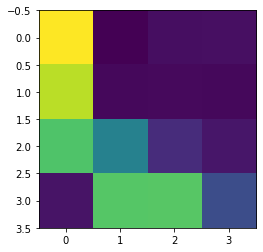

In [49]:
plt.imshow((reward_maxent_negative**10
           ).reshape(4,4))

In [28]:
total_episodes = 100000
learning_rate = 0.01
max_steps = 100
gamma = 0.99
exploration_rate = 1
max_exploration_rate = 1
min_exploration_rate = 0.01
exploration_decay_rate = 0.00005

alpha = 0.8

epsilon = 1.0
max_epsilon = 1.0
min_epsilon = 0.01
decay_rate = 0.01

In [29]:
env = gym.make('FrozenLake-v1', map_name="4x4", is_slippery=slippery)

new_q_table_neg = np.zeros((env.observation_space.n, env.action_space.n))
rewards_all_episodes = []

for episode in tqdm(range(total_episodes)):
    state = env.reset()[0]
    done = False
    rewards_current_episode = 0

    for step in range(max_steps):
        exploration_threshold = random.uniform(0, 1)
        if exploration_threshold > exploration_rate:
            action = np.argmax(new_q_table_neg[state, :])
        else:
            action = env.action_space.sample()
        new_state, _, done, info, prob = env.step(action)
        reward = (reward_maxent_negative**10)[new_state]
        new_q_table_neg[state, action] = new_q_table_neg[state, action] * (1 - learning_rate) + \
            learning_rate * (reward + gamma * np.max(new_q_table_neg[new_state, :]))
        state = new_state
        rewards_current_episode += reward
        if done:
            break
    exploration_rate = min_exploration_rate + \
        (max_exploration_rate - min_exploration_rate) * np.exp(-exploration_decay_rate * episode)
    rewards_all_episodes.append(rewards_current_episode)



100%|██████████| 100000/100000 [01:00<00:00, 1659.38it/s]


[0 3 3 3 0 0 2 0 3 1 0 0 0 2 1 0]


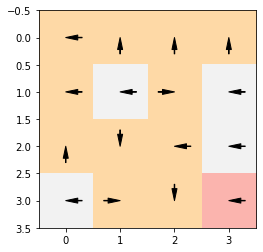

In [30]:
expert_policy = np.argmax(q_table,axis=1)
print(expert_policy)
plot_policy(policy)

[0 3 3 3 0 0 0 0 3 1 0 0 0 2 0 0]


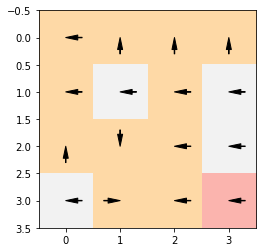

In [31]:
learned_policy_neg = np.argmax(new_q_table_neg,axis=1)
print(learned_policy_neg)
plot_policy(learned_policy_neg)

In [32]:
class QLearningAgent:
    def __init__(self, q_table):
        self.q_table = q_table

    def choose_action(self, state):
        return np.argmax(self.q_table[state, :])

expert_agent = QLearningAgent(q_table)
new_agent = QLearningAgent(new_q_table_neg)

def evaluate_agent(env, agent, episodes=1000):
    success = 0
    for _ in range(episodes):
        state = env.reset()[0]
        done = False
        while not done:
            action = agent.choose_action(state)
            next_state, _, done, _, _ = env.step(action)
            state = next_state
            if env.unwrapped.s == 14:  
                success += 1
                done = True
    return success / episodes
env = gym.make('FrozenLake-v1', map_name="4x4", is_slippery=slippery)

expert_success_rate = evaluate_agent(env, expert_agent)
new_agent_success_rate = evaluate_agent(env, new_agent)

print("Expert success rate: ", expert_success_rate)
print("New agent success rate: ", new_agent_success_rate)

Expert success rate:  0.857
New agent success rate:  0.879


We agent is still not reaching the goal, but it's reaching the tile before the goal